# System setting

In [1]:
from __future__ import division
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
import sys
# print (sys.path)
import math
import matplotlib.pyplot as plt
import sys

sys.path.append("..")
sys.path.append("/Users/marsliu/Documents/Github/trading-system/src")
import numpy as np
import sklearn
#from scipy import interp
#from numba import jit
import pandas as pd
from datetime import datetime
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.pipeline import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.decomposition import *
from sklearn.externals import joblib
from sklearn.utils import *
from copy import copy
from sklearn.feature_selection import SelectPercentile, f_classif
import os
from src.features import *
from imblearn.ensemble import *
from sklearn.model_selection import *
import time
#from time import time,mktime
from tpot import *
from copy import deepcopy
import seaborn as sns
import importlib 
import pickle
import seaborn
from collections import *
from catboost import *
import pandas_profiling
from src.models.training import *
from src.models.shadow_trade import *
from wrangle import *
import json
from sklearn.impute import SimpleImputer
import gc
import pandas_datareader.data as web
from xgboost import XGBClassifier

# General configuration

In [2]:
#  Download data
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#date format dd-mm-yyyy
class_label = 'binary-Both'  #(binary-(Both/Long/Short)/ multi)
iterations = 50 # Do not change it
ticker_org = '0688'#input("Stock: ")
ticker = ticker_org + ('.HK')
date = '01-01-2019'
date = pd.to_datetime(date, format='%m-%d-%Y', errors='ignore')
selected_model = 'sk'  #input ('Which model will you use? [sklearn(sk)/keras(k)/tpot')
Interval = 10  # k changing frequency in trading management
loop = 'n' ## for scikit-learn
if (selected_model == 'k' or selected_model == 'auto-k'):
    class_label = class_label + '-k'

evaluate_model = ''

# Definition

In [3]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    count = len(df_in)-len(df_out)
    print('Removed outlier: ' + str(count))
    return df_out
    
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

def memory_usage_mb(df, *args, **kwargs):
    """Dataframe memory usage in MB. """
    return df.memory_usage(*args, **kwargs).sum() / 1024**2

def reduce_memory_usage(df, deep=True, verbose=True):
    # All types that we want to change for "lighter" ones.
    # int8 and float16 are not include because we cannot reduce
    # those data types.
    # float32 is not include because float16 has too low precision.
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = memory_usage_mb(df, deep=deep)

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Log the conversion performed.
        if verbose and best_type is not None and best_type != str(col_type):
            print(f"Column '{col}' converted from {col_type} to {best_type}")

    if verbose:
        end_mem = memory_usage_mb(df, deep=deep)
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        print(f"Memory usage decreased from"
              f" {start_mem:.2f}MB to {end_mem:.2f}MB"
              f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
        
    return df

# Data Importation and processing


Reading data from Amibroker 
Successfully retrieved primary data
Primary Data:  5038
-----------------------------------------------------------
Data processing....


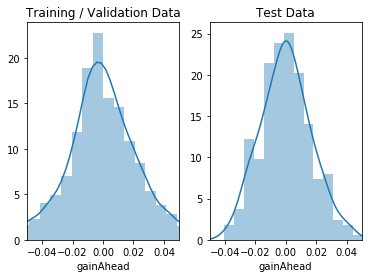

2006-05-16 00:00:00 2018-12-28 00:00:00
2019-01-02 00:00:00 2020-02-28 00:00:00
Data processing completed
Processed Data:  2575
Erased Data:  364
Total number of X:  1568
-----------------------------------------------------------
Original data distribution:  Counter({-1: 1395, 1: 1180})
-----------------------------------------------------------
CPU times: user 9.82 s, sys: 712 ms, total: 10.5 s
Wall time: 39.8 s


9270

In [4]:
%%time
print ("\nReading data from Amibroker ")
qt = pd.DataFrame()
qt = pd.read_csv('../data/raw/%s.csv' % ticker, index_col=False,header=None,encoding='utf-8')
qt.columns=['Ticker','Date','Open','High','Low','Close','Volume']
ticker = qt.Ticker.iloc[0]

print ("Successfully retrieved primary data")
dataSet = qt
nrows = qt.shape[0]
print ("Primary Data: ", nrows)
print ('-----------------------------------------------------------')
print ('Data processing....')

dataSet = features_engineering(dataSet, class_label)
# dataSet = bd.dataimport(dataSet, class_label)
#from statsmodels.tsa.arima_model import ARIMA
#arima = ARIMA(dataSet.Close, order=(5, 1, 0))
#arima = arima.fit(disp=0)
#output = arima.forecast()
# stocks = ['0001','0002','0003','0004','0005','0006','0017','0027','0175','0386','0388','0688','0700','0883','0939','0941','1299','1398','1800','1928','2318','2628','3988']
stocks = []
index=0
while index < len(stocks):
    if stocks[index] != ticker_org:
        ticker_features = stocks[index] + '.HK'
        qt_new = pd.DataFrame()
        qt_new = pd.read_csv('../data/raw/%s.csv' % ticker_features, index_col=False,header=None,encoding='utf-8')
        qt_new.columns=['Ticker','Date','Open','High','Low','Close','Volume']
        bd.dataimport_related_assets(qt_new,ticker_features)
        qt_new = qt_new.drop(['Ticker','Open','High','Low','Close','Volume'],axis=1)
        dataSet = pd.merge(dataSet, qt_new, how = 'inner', on = 'Date')
        del stocks[index]
        continue
    index+=1

# dataSet = reduce_memory_usage(dataSet)    
    
mData = dataSet[dataSet['Date']<date]
validationData = dataSet[dataSet['Date']>=date]
original_sample = mData.shape[0]

mData, validationData = features_add_cut(mData, validationData, ['Pri_RSI'])

# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# mData = imp_mean.fit_transform(mData)
# validationData = imp_mean.transform(validationData)

# mData, validationData = df_autoclean_cv(mData, validationData)

# mData = remove_outlier(mData,'gainAhead')
plt.subplot(121)
plt.title('Training / Validation Data')
seaborn.distplot(mData.gainAhead).set(xlim=(-0.05,0.05))
plt.subplot(122)
plt.title('Test Data')
seaborn.distplot(validationData.gainAhead).set(xlim=(-0.05,0.05))
plt.show()
plt.close()

print (mData.Date.min(), mData.Date.max())
print (validationData.Date.min(), validationData.Date.max())
mData = mData.drop(['Ticker','Date','Open','High','Low','Close',
                       'Volume','gainAhead'],
                        axis=1)
validationData = validationData.drop(['Ticker','Open','High','Low','Close',
                       'Volume'],
                        axis=1)

# while index < len(stocks):
#     if stocks[index] != ticker_org:
#         ticker_features = stocks[index] + '.HK'
#         qt_new = pd.DataFrame()
#         qt_new = pd.read_csv('./Training Dataset/%s.csv' % ticker_features, index_col=False,header=None,encoding='utf-8')
#         qt_new.columns=['Ticker','Date','Open','High','Low','Close','Volume']
#         qt_new = bd.dataimport_original(qt_new,class_label)
#         qt_new = qt_new[qt_new['Date']<date]
#         qt_new = qt_new.drop(['Ticker','Date','Open','High','Low','Close',
#                        'Volume','Pri','gainAhead'],axis=1)
#         mData = pd.concat([mData, qt_new])
#         del stocks[index]
#         continue
#     index+=1

mData = mData.replace([np.inf, -np.inf], np.nan).fillna(method='ffill')
validationData = validationData.replace([np.inf, -np.inf], np.nan).fillna(method='ffill')
mData = mData.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
validationData = validationData.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
test_lowerbound = validationData['Date'].min().strftime('%m-%d-%Y')
            
vData = validationData.drop(['Date','gainAhead','beBoth'],axis=1)
datay = mData.beBoth
dataX = mData.drop(['beBoth'],axis=1)

#ptr = pandas_profiling.ProfileReport(dataSet)
#ptr.to_file('./Profiling Report/%s report.html'% (str(ticker)))

#  Copy from pandas dataframe to numpy arrays
# dy = np.zeros_like(datay)
# dX = np.zeros_like(dataX)

# dy = datay.values
# dX = dataX.values

print ('Data processing completed')
print ('Processed Data:  ' + str(dataX.shape[0]))
print ('Erased Data:  ' + str(original_sample - dataX.shape[0]))
print ('Total number of X:  ' + str(dataX.shape[1]))
print ('-----------------------------------------------------------')

print('Original data distribution: ', Counter(datay))

print ('-----------------------------------------------------------')
trainRows = dataX.shape[0]
ncols = dataX.shape[1]*1
samples = dataX.shape[0]
# sample_weight = compute_sample_weight(class_weight='balanced', y=datay)
gc.collect()

# Features processing

In [5]:
# processor = preprocessing(dataX,datay,vData)
# dataX, datay = processor.balancing(plot = False)
# dataX = pd.DataFrame(dataX)
# dataX.columns = mData.drop('beBoth', axis=1).columns.tolist()
# datay = pd.DataFrame(datay)

# processor = preprocessing(dataX,datay,vData)
# dataX, vData = processor.GA_dim()
class_weights = get_class_weights(datay)

In [25]:
stock = []
final_equity = []
train_period = []
test_period = []
with open('../docs/rolling_result.json') as infile:
    rolling_result = json.load(infile)
    for p in rolling_result:
        stock.append(p['stock'])
        final_equity.append(p['final_equity'])
        train_period.append(p['final_train_period'])
        test_period.append(p['final_test_period'])

rolling_period_df = pd.DataFrame([stock, final_equity, train_period,test_period]).transpose()
rolling_period_df.columns=['Stock', 'equity', 'train_period', 'test_period']

train_period = rolling_period_df[rolling_period_df['Stock'] == ticker].iloc[0]['train_period']
test_period = rolling_period_df[rolling_period_df['Stock'] == ticker].iloc[0]['test_period']

# train = training(dataX, datay, iterations, class_label, ticker)
# model, equity, last_train_period, dataX, datay, validationData, vData = train.rolling_test(dataSet=dataSet, train_period=train_period, test_period=test_period, class_label=class_label, bt = False)

# Model training

In [48]:
cv = model_find_cv(dataX, datay)

     IQR   CV  acc_mean
0  0.031  sss     0.525
1  0.038  skf     0.521
2  0.029   rs     0.518


In [6]:
cols = list(dataX)

In [7]:
train = training(dataX, datay, 10, class_label, ticker)
if (selected_model == 'sk'):
    
    model = LogisticRegression()
#     model = EasyEnsembleClassifier(n_jobs=-1)
#     model = BalancedBaggingClassifier()
#     model = BalancedRandomForestClassifier()
#     model = RUSBoostClassifier()
#     model = LinearSVC(class_weight = class_weights)
    #model = ExtraTreesClassifier()
#     model = SVC(class_weight = class_weights, probability = True)
#     model = BernoulliNB()
#     model = AdaBoostClassifier()
#     model = GradientBoostingClassifier()
#     model = ExtraTreesClassifier(class_weight = class_weights)
#     model = XGBClassifier()
#     model = train.sk(model = model)
    model.fit(dataX[cols], datay)
#     model.fit(dataX,datay)

# elif (selected_model == 'tpot'):
#     model, prev_tpot = train.tpot(scoring = 'roc_auc', cv = cv)


# Previous model checking and loading

In [ ]:
prev_model_path = './original pkl/%s(%s).pkl' % (class_label,ticker)
if os.path.isfile(prev_model_path) :
            # ------------------prev model---------------------
            print ("Previous trained model exists")
            prev = True
            if (selected_model == 'sk' or selected_model == 'tpot'):
                model = joblib.load(prev_model_path)
            elif (selected_model == 'k' or selected_model == 'auto-k'):
                model = load_model(prev_model_path)
            elif (selected_model == 'catboost'):
                from_file = CatBoostClassifier()
                model = from_file.load_model(fname=prev_model_path,format='coreml')
prev_model_path

# Backtest and Model Evaluation

In [8]:
trading = trade(model, dataX, datay, validationData, vData[cols], class_label, ticker,selected_model)


Beginning validation of period
Validation Data from 2019-11-08 00:00:00 to 2020-02-28 00:00:00.
Last date of prediction :  2020-02-28 00:00:00

This system is:  binary-Both

Terminal wealth (current trained model)  : 1.25
Classification report of current trained model:
              precision    recall  f1-score   support

       Short       0.59      0.83      0.69        35
        Long       0.68      0.39      0.50        33

    accuracy                           0.62        68
   macro avg       0.64      0.61      0.60        68
weighted avg       0.64      0.62      0.60        68



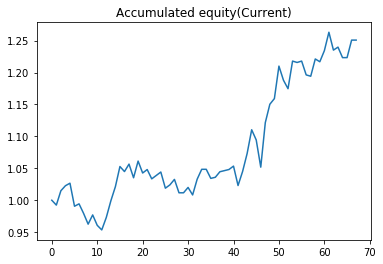

1.25

<Figure size 432x288 with 0 Axes>

In [9]:
y_validate, y_validate_prev, prev = trading.stage1_prediction()
trading.stage1_validation(y_validate, y_validate_prev, prev)